In [17]:
import torch
import json
import os
from diffusers import DPMSolverMultistepScheduler, AutoencoderKL

from nets.transformer_2d import Transformer2DModel
from nets.pipeline import DiTPipeline

import matplotlib.pyplot as plt

In [2]:
# 模型路径
model_path = "model_data/DiT-XL-2-256"

# 初始化DiT的各个组件

In [3]:
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_path, subfolder="scheduler")
scheduler

DPMSolverMultistepScheduler {
  "_class_name": "DPMSolverMultistepScheduler",
  "_diffusers_version": "0.26.3",
  "algorithm_type": "dpmsolver++",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": false,
  "dynamic_thresholding_ratio": 0.995,
  "euler_at_final": false,
  "final_sigmas_type": "zero",
  "lambda_min_clipped": -Infinity,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "solver_order": 2,
  "solver_type": "midpoint",
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false,
  "use_lu_lambdas": false,
  "variance_type": null
}

In [4]:
transformer = Transformer2DModel.from_pretrained(model_path, subfolder="transformer")
transformer

Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-27): 28 x BasicTransformerBlock(
      (norm1): AdaLayerNormZero(
        (emb): CombinedTimestepLabelEmbeddings(
          (time_proj): Timesteps()
          (timestep_embedder): TimestepEmbedding(
            (linear_1): Linear(in_features=256, out_features=1152, bias=True)
            (act): SiLU()
            (linear_2): Linear(in_features=1152, out_features=1152, bias=True)
          )
          (class_embedder): LabelEmbedding(
            (embedding_table): Embedding(1001, 1152)
          )
        )
        (silu): SiLU()
        (linear): Linear(in_features=1152, out_features=6912, bias=True)
        (norm): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      )
      (attn1): Attention(
        (to_q): Linear(in_features=1152, out_features=1152, bias=True)
        (to_k): Linear(in_features=1152, out_features=115

In [5]:
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")
vae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [6]:
id2label = json.load(open(os.path.join(model_path, "model_index.json"), "r"))['id2label']
id2label

{'0': 'tench, Tinca tinca',
 '1': 'goldfish, Carassius auratus',
 '2': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 '3': 'tiger shark, Galeocerdo cuvieri',
 '4': 'hammerhead, hammerhead shark',
 '5': 'electric ray, crampfish, numbfish, torpedo',
 '6': 'stingray',
 '7': 'cock',
 '8': 'hen',
 '9': 'ostrich, Struthio camelus',
 '10': 'brambling, Fringilla montifringilla',
 '11': 'goldfinch, Carduelis carduelis',
 '12': 'house finch, linnet, Carpodacus mexicanus',
 '13': 'junco, snowbird',
 '14': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 '15': 'robin, American robin, Turdus migratorius',
 '16': 'bulbul',
 '17': 'jay',
 '18': 'magpie',
 '19': 'chickadee',
 '20': 'water ouzel, dipper',
 '21': 'kite',
 '22': 'bald eagle, American eagle, Haliaeetus leucocephalus',
 '23': 'vulture',
 '24': 'great grey owl, great gray owl, Strix nebulosa',
 '25': 'European fire salamander, Salamandra salamandra',
 '26': 'common newt, Triturus vulga

In [7]:
# 初始化DiT的Pipeline
pipe = DiTPipeline(scheduler=scheduler, transformer=transformer, vae=vae, id2label=id2label)
pipe = pipe.to("cuda")
pipe

DiTPipeline {
  "_class_name": "DiTPipeline",
  "_diffusers_version": "0.26.3",
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "transformer": [
    "nets.transformer_2d",
    "Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# generate

In [9]:
# imagenet种类 对应的 名称
words = ["white shark", "umbrella"]
# 获得imagenet对应的ids
class_ids = pipe.get_label_ids(words)
class_ids

[2, 879]

In [10]:
# 设置seed
generator = torch.manual_seed(42)
generator

# pipeline前传

In [11]:
output = pipe(class_labels=class_ids, num_inference_steps=25, generator=generator)
output

  0%|          | 0/25 [00:00<?, ?it/s]

d:\miniconda3\envs\pytorch\Lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


ImagePipelineOutput(images=[<PIL.Image.Image image mode=RGB size=256x256 at 0x277D07E4610>, <PIL.Image.Image image mode=RGB size=256x256 at 0x277D060FCD0>])

# 显示图片

In [14]:
output.images

[<PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>]

In [16]:
output.images[0]

(<PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>)

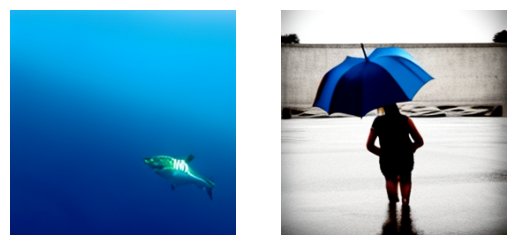

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for image, ax in zip(output.images, axes):
    ax.imshow(image)
    ax.axis('off')